In [ ]:
# !pip install catboost

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
# set the aesthetic style of the plots
sns.set_style()
# filter warning messages
import warnings
warnings.filterwarnings('ignore')

## **Credit risk** is associated with the possibility of a client failing to meet contractual loan obligations.

### Minimizing the **risk** of **default** is a major concern for financial institutions. Banks and financial institutions firms are increasingly relying on **technology** to predict which clients are more prone to not honoring their debts.

### Machine Learning models have been helping these companies to improve the accuracy of their credit risk analysis,  to identify potential debtors in advance.

### Here: we will build a model to predict the risk of client default for Nubank, a prominent Brazilian Fintech.

In [ ]:
df_credit = pd.read_csv('http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0')
df_credit.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


## Exploratory Data Analysis

#### What is the shape of the dataset? What are the features?

In [ ]:
print('Number of rows: ', df_credit.shape[0])
print('Number of columns: ', df_credit.shape[1])

df_credit.info()

Number of rows:  45000
Number of columns:  43
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         

#### **`target_default`** is a True/False feature and is the target variable we are trying to predict.

#### Next, let us find the percentage of missing values per feature.

In [ ]:
print((df_credit.isnull().sum() * 100 / df_credit.shape[0]).sort_values(ascending=False))

target_fraud                                        96.617778
last_borrowed_in_months                             66.568889
last_amount_borrowed                                66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

#### **`target_default`** is our independent variable. 7.24% of our target is missing, so we can drop the missing values for this target.

#### Next, we drop several columns that are not useful for our analysis, like **`target_fraud`**

In [ ]:
df_credit.dropna(subset=['target_default'], inplace=True)
df_credit.drop('target_fraud', axis=1, inplace=True)

In [ ]:
print(df_credit.nunique().sort_values()) # number of unique observations per column

df_credit.drop(labels=['channel', 'external_data_provider_credit_checks_last_2_year','email', 'reason', 'zip', 'job_name', 'external_data_provider_first_name', 'lat_lon',
                       'shipping_zip_code', 'user_agent', 'profile_tags', 'marketing_channel','profile_phone_number', 'application_time_applied', 'ids'], axis=1, inplace=True)

external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_default                                          2
last_borrowed_in_months                                 2
facebook_profile                                        2
external_data_provider_credit_checks_last_year          2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts                                             44
state         

In [ ]:
df_credit.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,...,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_state
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,...,0.0,18.0,18.0,444,2,0.0,51.0,645,57849.0,BR-MT
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,...,0.0,14.0,14.0,346,1,0.0,17.0,243,4902.0,BR-RS
2,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,...,0.0,10.0,NaN,6,2,NaN,9.0,65,163679.0,BR-RR
3,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,...,0.0,19.0,19.0,406,3,NaN,38.0,815,1086.0,BR-RN
4,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,...,0.0,11.0,NaN,240,2,1.0,46.0,320,198618.0,BR-MT


## Next, let us look as **summary statistics** and see if we are dealing with any outliers.

In [ ]:
df_credit.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
count,41741.000000,41741.000000,41741.000000,41741.000000,41741.000000,14133.000000,14133.000000,28632.000000,4.174100e+04,17276.000000,41606.000000,41729.000000,41741.000000,30818.000000,41741.000000,41741.000000,27720.000000,39656.000000,41741.000000,41741.0
mean,346.459836,100.006820,0.499416,99.919399,0.294451,13328.104095,40.588410,33877.220453,7.108012e+04,35.192174,0.076696,0.004625,10.639108,11.023882,247.748545,1.504396,0.504185,12.731188,500.491771,inf
std,110.102271,3.183821,0.288085,10.022703,0.101561,7918.698433,9.437936,36141.985884,5.225978e+04,21.629577,0.274820,0.080157,4.588175,4.596036,146.326172,1.114207,0.499992,125.711218,287.993121,NaN
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,403.0
25%,270.000000,97.862546,0.251595,93.182517,0.220000,7210.280000,36.000000,9975.000000,4.401958e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,11.000000,252.000000,50910.0
50%,340.000000,100.017950,0.500174,99.977774,0.290000,12011.050000,36.000000,25213.000000,6.004409e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,27.000000,502.000000,101623.0
75%,420.000000,102.143100,0.747630,106.630991,0.360000,18030.160000,36.000000,46492.500000,8.503289e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,43.000000,747.000000,151248.0
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,inf


In [ ]:
df_credit['reported_income'] = df_credit['reported_income'].replace(np.inf, np.nan) # replace "inf" values with "nan"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'] = np.nan # replace "-999" values with "nan"

In [ ]:
df_credit.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
count,41741.000000,41741.000000,41741.000000,41741.000000,41741.000000,14133.000000,14133.000000,28632.000000,4.174100e+04,17276.000000,41606.000000,41729.000000,41741.000000,30818.000000,41741.000000,41741.000000,27720.000000,39065.000000,41741.000000,4.167500e+04
mean,346.459836,100.006820,0.499416,99.919399,0.294451,13328.104095,40.588410,33877.220453,7.108012e+04,35.192174,0.076696,0.004625,10.639108,11.023882,247.748545,1.504396,0.504185,28.037297,500.491771,1.052261e+13
std,110.102271,3.183821,0.288085,10.022703,0.101561,7918.698433,9.437936,36141.985884,5.225978e+04,21.629577,0.274820,0.080157,4.588175,4.596036,146.326172,1.114207,0.499992,17.945808,287.993121,2.583937e+14
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,4.030000e+02
25%,270.000000,97.862546,0.251595,93.182517,0.220000,7210.280000,36.000000,9975.000000,4.401958e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,12.000000,252.000000,5.083400e+04
50%,340.000000,100.017950,0.500174,99.977774,0.290000,12011.050000,36.000000,25213.000000,6.004409e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,28.000000,502.000000,1.014210e+05
75%,420.000000,102.143100,0.747630,106.630991,0.360000,18030.160000,36.000000,46492.500000,8.503289e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,44.000000,747.000000,1.511095e+05
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,6.355500e+15


In [ ]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41741 entries, 0 to 44999
Data columns (total 27 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   target_default                                   41741 non-null  object 
 1   score_1                                          41741 non-null  object 
 2   score_2                                          41741 non-null  object 
 3   score_3                                          41741 non-null  float64
 4   score_4                                          41741 non-null  float64
 5   score_5                                          41741 non-null  float64
 6   score_6                                          41741 non-null  float64
 7   risk_rate                                        41741 non-null  float64
 8   last_amount_borrowed                             14133 non-null  float64
 9   last_borrowed_in_months          

##### Plot a histogram for each of the numerical features.

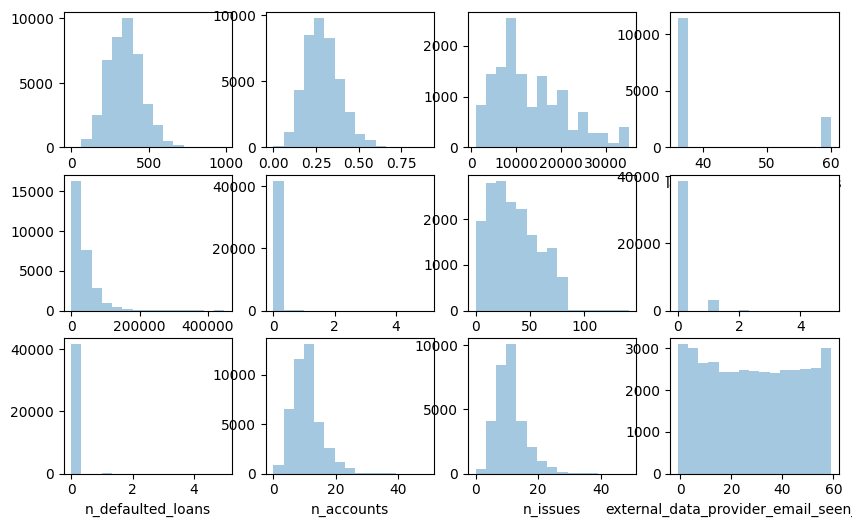

In [ ]:
df_credit_numerical = df_credit[['score_3', 'risk_rate', 'last_amount_borrowed', 'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since',
                                 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues', 'external_data_provider_email_seen_before']]

nrows = 3
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))

r = 0
c = 0
for i in df_credit_numerical:
  sns.distplot(df_credit_numerical[i], bins=15,kde=False, ax=ax[r][c])
  if c == ncols - 1:
    r += 1
    c = 0
  else:
    c += 1

plt.show()

## **MISSING VALUES.**

We are filling mising values according to the particularities of each feature, as below:

Categorical variables will be filled with the most recurrent value.

*   **Categorical** variables will be filled with the most recurrent value.
*   **Numerical** variables will be filled with their median values.
*   In the specific cases of `last_amount_borrowed`, `last_borrowed_in_months` and `n_issues` we'll fill the missing values with zero, as it is reasonable to believe that not every client would have values assigned to these variables.




In [ ]:
df_credit_num = df_credit.select_dtypes(exclude='object').columns
df_credit_cat = df_credit.select_dtypes(include='object').columns

# fill missing values for "last_amount_borrowed", "last_borrowed_in_months" and "n_issues"
df_credit['last_amount_borrowed'].fillna(value=0, inplace=True)
df_credit['last_borrowed_in_months'].fillna(value=0, inplace=True)
df_credit['n_issues'].fillna(value=0, inplace=True)

# fill missing values for numerical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_credit.loc[:, df_credit_num])
df_credit.loc[:, df_credit_num] = imputer.transform(df_credit.loc[:, df_credit_num])

# fill missing values for categorical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_credit.loc[:, df_credit_cat])
df_credit.loc[:, df_credit_cat] = imputer.transform(df_credit.loc[:, df_credit_cat])

### We'll now preprocess the data, converting the categorical features into numerical values. `LabelEncoder` will be used for the binary variables while `get_dummies` will be used for the other categorical variables.

In [ ]:
bin_var = df_credit.nunique()[df_credit.nunique() == 2].keys().tolist()
num_var = [col for col in df_credit.select_dtypes(['int', 'float']).columns.tolist() if col not in bin_var]
cat_var = [col for col in df_credit.select_dtypes(['object']).columns.tolist() if col not in bin_var]

df_credit_encoded = df_credit.copy()

# label encoding for the binary variables
le = LabelEncoder()
for col in bin_var:
  df_credit_encoded[col] = le.fit_transform(df_credit_encoded[col])

# encoding with get_dummies for the categorical variables
df_credit_encoded = pd.get_dummies(df_credit_encoded, columns=cat_var)

df_credit_encoded.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,...,shipping_state_BR-PE,shipping_state_BR-PR,shipping_state_BR-RN,shipping_state_BR-RO,shipping_state_BR-RR,shipping_state_BR-RS,shipping_state_BR-SC,shipping_state_BR-SE,shipping_state_BR-SP,shipping_state_BR-TO
0,0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,...,False,False,False,False,False,False,False,False,False,False
1,0,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,...,False,False,False,False,False,True,False,False,False,False
2,1,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,...,False,False,False,False,True,False,False,False,False,False
3,0,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,...,False,False,True,False,False,False,False,False,False,False
4,0,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,...,False,False,False,False,False,False,False,False,False,False


### Train-test Split for Machine Learning

In [ ]:
X = df_credit_encoded.drop('target_default', axis=1)
y = df_credit_encoded['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [ ]:
# standardize and resample the training set
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

## Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_rus, y_train_rus)
predictions = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7190768985067476


              precision    recall  f1-score   support

           0       0.88      0.77      0.82     10525
           1       0.27      0.44      0.33      1998

    accuracy                           0.72     12523
   macro avg       0.57      0.60      0.58     12523
weighted avg       0.78      0.72      0.74     12523



Text(50.722222222222214, 0.5, 'Real Value')

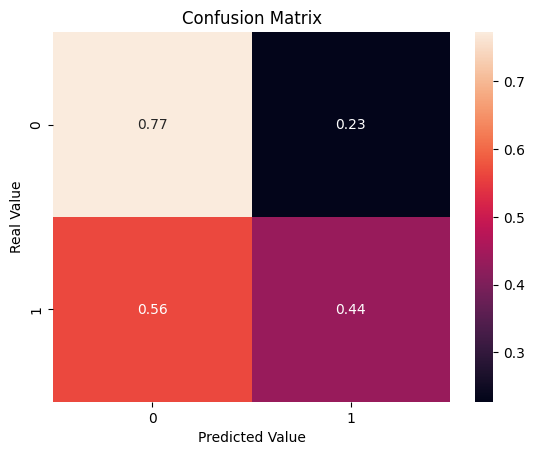

In [ ]:
# classification report
print(classification_report(y_test, predictions))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, predictions, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

## Decision Tree Classifier

0.4111634592350076
              precision    recall  f1-score   support

           0       0.87      0.35      0.50     10525
           1       0.17      0.72      0.28      1998

    accuracy                           0.41     12523
   macro avg       0.52      0.53      0.39     12523
weighted avg       0.76      0.41      0.47     12523



Text(50.722222222222214, 0.5, 'Real Value')

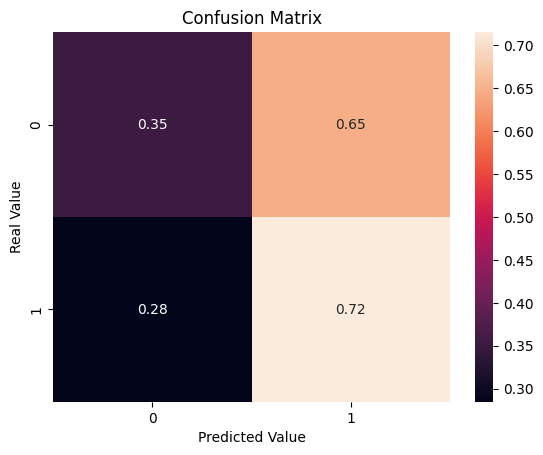

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_rus, y_train_rus)
y_pred = dtc.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

In [ ]:
# ig = plt.figure(figsize=(20,20))
# tree.plot_tree(dtc, label='root', fontsize=9, class_names=['Low', 'High'], filled=True);


In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_rus, y_train_rus)
y_pred = dtc.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_rus, y_train_rus)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')



Classification Report (K-NN):
               precision    recall  f1-score   support

           0       0.84      0.76      0.80     10525
           1       0.16      0.23      0.19      1998

    accuracy                           0.68     12523
   macro avg       0.50      0.50      0.49     12523
weighted avg       0.73      0.68      0.70     12523



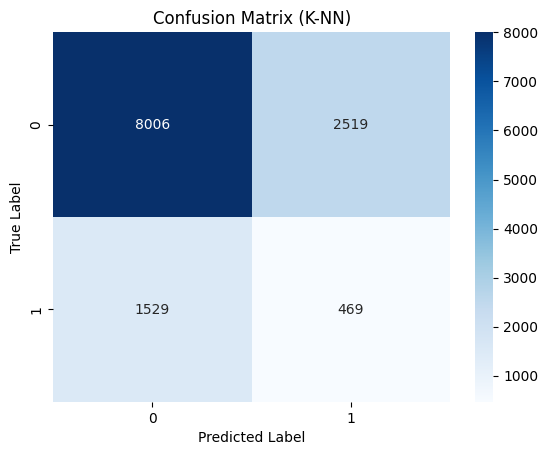

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create and train the K-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (n_neighbors)
knn.fit(X_train_rus, y_train_rus)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test)

# Print the classification report
print("Classification Report (K-NN):\n", classification_report(y_test, y_pred_knn))

# Create and display the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots()
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix (K-NN)")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.show()

0.8404535654395912
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     10525
           1       0.00      0.00      0.00      1998

    accuracy                           0.84     12523
   macro avg       0.42      0.50      0.46     12523
weighted avg       0.71      0.84      0.77     12523



Text(50.722222222222214, 0.5, 'Real Value')

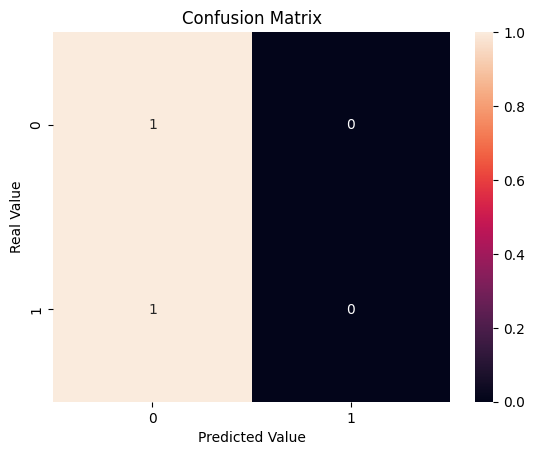

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_rus, y_train_rus)
y_pred = logreg.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')


0.8404535654395912
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     10525
           1       0.00      0.00      0.00      1998

    accuracy                           0.84     12523
   macro avg       0.42      0.50      0.46     12523
weighted avg       0.71      0.84      0.77     12523



Text(50.722222222222214, 0.5, 'Real Value')

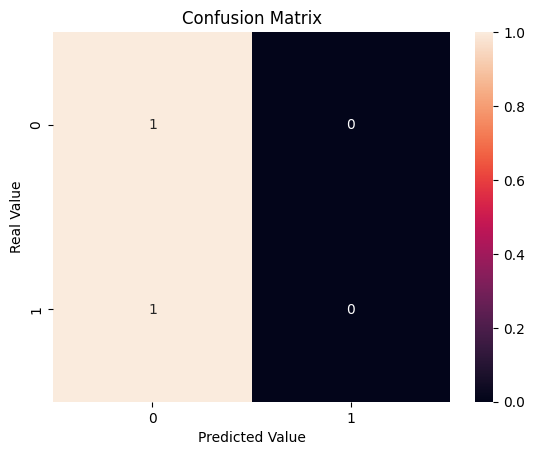

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_rus, y_train_rus)
y_pred = logreg.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')